In [1]:
# This R environment comes with all of CRAN preinstalled, as well as many other helpful packages
# The environment is defined by the kaggle/rstats docker image: https://github.com/kaggle/docker-rstats
# For example, here's several helpful packages to load in 

library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

system("ls ../input")

# Any results you write to the current directory are saved as output.

In [2]:
library(arules)
library(arulesViz)
library(data.table)
library(zoo)
library(forecast)
library(ggplot2)
test <- fread("../input/test.csv")
train <- fread("../input/train.csv")
store <- fread("../input/store.csv")

Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: grid

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘forecast’

The following object is masked from ‘package:ggplot2’:

    autolayer



In [3]:
str(train)


Classes ‘data.table’ and 'data.frame':	1017209 obs. of  9 variables:
 $ Store        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ DayOfWeek    : int  5 5 5 5 5 5 5 5 5 5 ...
 $ Date         : chr  "2015-07-31" "2015-07-31" "2015-07-31" "2015-07-31" ...
 $ Sales        : int  5263 6064 8314 13995 4822 5651 15344 8492 8565 7185 ...
 $ Customers    : int  555 625 821 1498 559 589 1414 833 687 681 ...
 $ Open         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Promo        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ StateHoliday : chr  "0" "0" "0" "0" ...
 $ SchoolHoliday: chr  "1" "1" "1" "1" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [4]:
str(store)

Classes ‘data.table’ and 'data.frame':	1115 obs. of  10 variables:
 $ Store                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ StoreType                : chr  "c" "a" "a" "c" ...
 $ Assortment               : chr  "a" "a" "a" "c" ...
 $ CompetitionDistance      : int  1270 570 14130 620 29910 310 24000 7520 2030 3160 ...
 $ CompetitionOpenSinceMonth: int  9 11 12 9 4 12 4 10 8 9 ...
 $ CompetitionOpenSinceYear : int  2008 2007 2006 2009 2015 2013 2013 2014 2000 2009 ...
 $ Promo2                   : int  0 1 1 0 0 0 0 0 0 0 ...
 $ Promo2SinceWeek          : int  NA 13 14 NA NA NA NA NA NA NA ...
 $ Promo2SinceYear          : int  NA 2010 2011 NA NA NA NA NA NA NA ...
 $ PromoInterval            : chr  "" "Jan,Apr,Jul,Oct" "Jan,Apr,Jul,Oct" "" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [5]:
summary(train)

     Store          DayOfWeek         Date               Sales      
 Min.   :   1.0   Min.   :1.000   Length:1017209     Min.   :    0  
 1st Qu.: 280.0   1st Qu.:2.000   Class :character   1st Qu.: 3727  
 Median : 558.0   Median :4.000   Mode  :character   Median : 5744  
 Mean   : 558.4   Mean   :3.998                      Mean   : 5774  
 3rd Qu.: 838.0   3rd Qu.:6.000                      3rd Qu.: 7856  
 Max.   :1115.0   Max.   :7.000                      Max.   :41551  
   Customers           Open            Promo        StateHoliday      
 Min.   :   0.0   Min.   :0.0000   Min.   :0.0000   Length:1017209    
 1st Qu.: 405.0   1st Qu.:1.0000   1st Qu.:0.0000   Class :character  
 Median : 609.0   Median :1.0000   Median :0.0000   Mode  :character  
 Mean   : 633.1   Mean   :0.8301   Mean   :0.3815                     
 3rd Qu.: 837.0   3rd Qu.:1.0000   3rd Qu.:1.0000                     
 Max.   :7388.0   Max.   :1.0000   Max.   :1.0000                     
 SchoolHoliday     


In [6]:
total <-merge(train, store, by="Store")
head(total)

Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,NA,NA,
1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270,9,2008,0,NA,NA,
1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270,9,2008,0,NA,NA,
1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270,9,2008,0,NA,NA,
1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270,9,2008,0,NA,NA,
1,7,2015-07-26,0,0,0,0,0,0,c,a,1270,9,2008,0,NA,NA,


In [7]:
df <- subset(total, select = c(7, 9, 15, 4))

In [8]:
str(df)

Classes ‘data.table’ and 'data.frame':	1017209 obs. of  4 variables:
 $ Promo        : int  1 1 1 1 1 0 0 0 0 0 ...
 $ SchoolHoliday: chr  "1" "1" "1" "1" ...
 $ Promo2       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Sales        : int  5263 5020 4782 5011 6102 0 4364 3706 3769 3464 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
head(df)

Promo,SchoolHoliday,Promo2,Sales
1,1,0,5263
1,1,0,5020
1,1,0,4782
1,1,0,5011
1,1,0,6102
0,0,0,0


In [10]:
# These Threshold i have according to mean value os sales
df$Sale[df$Sales < 2000] <- "low"
df$Sale[df$Sales >= 2000 & df$Sales < 7000] <- "Average"
df$Sale[df$Sales >= 7000] <- "High"

In [11]:
head(df)

Promo,SchoolHoliday,Promo2,Sales,Sale
1,1,0,5263,Average
1,1,0,5020,Average
1,1,0,4782,Average
1,1,0,5011,Average
1,1,0,6102,Average
0,0,0,0,low


In [12]:
df <- within(df, rm(Sales))
head(df)

Promo,SchoolHoliday,Promo2,Sale
1,1,0,Average
1,1,0,Average
1,1,0,Average
1,1,0,Average
1,1,0,Average
0,0,0,low


In [13]:
df <- as.data.frame(df)
df <- df[complete.cases(df),]
df$Promo <-as.factor(df$Promo)
df$SchoolHoliday <-as.factor(df$SchoolHoliday)
df$Promo2 <-as.factor(df$Promo2)
df$Sale <-as.factor(df$Sale)
str(df)
trans <- as(df, "transactions")
rules <- apriori(trans, parameter = list(supp = 0.090, conf = 0.15), appearance = list(rhs=c("Sale=Average", "Sale=High", "Sale=low"), 
                                     default="lhs"))

'data.frame':	1017209 obs. of  4 variables:
 $ Promo        : Factor w/ 2 levels "0","1": 2 2 2 2 2 1 1 1 1 1 ...
 $ SchoolHoliday: Factor w/ 2 levels "0","1": 2 2 2 2 2 1 1 1 1 1 ...
 $ Promo2       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ Sale         : Factor w/ 3 levels "Average","High",..: 1 1 1 1 1 3 1 1 1 1 ...
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.15    0.1    1 none FALSE            TRUE       5    0.09      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 91548 

set item appearances ...[3 item(s)] done [0.00s].
set transactions ...[9 item(s), 1017209 transaction(s)] done [0.13s].
sorting and recoding items ... [9 item(s)] done [0.02s].
creating transaction tree ... done [0.43s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [32 rule(s)

Total we have made 32 rules. These rules are dependent on support and confidence.These counting of these rules can be changed by changing the values of support and confidence by trial and error method.

**Support:** Support is the basic probability of an event to occur. If we have an event to buy product A, Support(A) is the number of transactions which includes A divided by total number of transactions.

**Confidence:** The confidence of an event is the conditional probability of the occurrence; the chances of A happening given B has already happened.

**Lift:** This is the ratio of confidence to expected confidence.The probability of all of the items in a rule occurring together (otherwise known as the support) divided by the product of the probabilities of the items on the left and right side occurring as if there was no association between them.

The lift value tells us how much better a rule is at predicting something than randomly guessing. The higher the lift, the stronger the association.

In [14]:
rules <- sort(rules, by = "lift", decreasing='true')
head(inspect(rules))

     lhs                                   rhs            support    confidence
[1]  {Promo=1,SchoolHoliday=0,Promo2=0} => {Sale=High}    0.09446436 0.6311786 
[2]  {Promo=1,Promo2=0}                 => {Sale=High}    0.12010806 0.6295604 
[3]  {Promo=1}                          => {Sale=High}    0.22328843 0.5852685 
[4]  {Promo=1,SchoolHoliday=0}          => {Sale=High}    0.17587438 0.5846858 
[5]  {Promo=0,SchoolHoliday=0}          => {Sale=low}     0.15033980 0.2888085 
[6]  {Promo=1,Promo2=1}                 => {Sale=High}    0.10318037 0.5409657 
[7]  {Promo=0}                          => {Sale=low}     0.16438313 0.2657833 
[8]  {Promo=0,Promo2=1}                 => {Sale=Average} 0.18096183 0.5840679 
[9]  {Promo=0,SchoolHoliday=0,Promo2=1} => {Sale=Average} 0.14829892 0.5674888 
[10] {Promo=0}                          => {Sale=Average} 0.33896181 0.5480514 
[11] {Promo2=0}                         => {Sale=High}    0.18964834 0.3797249 
[12] {Promo=0,SchoolHoliday=0}          

,lhs,,rhs,support,confidence,lift,count
[1],"{Promo=1,SchoolHoliday=0,Promo2=0}",=>,{Sale=High},0.09446436,0.6311786,1.865025,96090
[2],"{Promo=1,Promo2=0}",=>,{Sale=High},0.12010806,0.6295604,1.860244,122175
[3],{Promo=1},=>,{Sale=High},0.22328843,0.5852685,1.729369,227131
[4],"{Promo=1,SchoolHoliday=0}",=>,{Sale=High},0.17587438,0.5846858,1.727647,178901
[5],"{Promo=0,SchoolHoliday=0}",=>,{Sale=low},0.15033980,0.2888085,1.644685,152927
[6],"{Promo=1,Promo2=1}",=>,{Sale=High},0.10318037,0.5409657,1.598462,104956


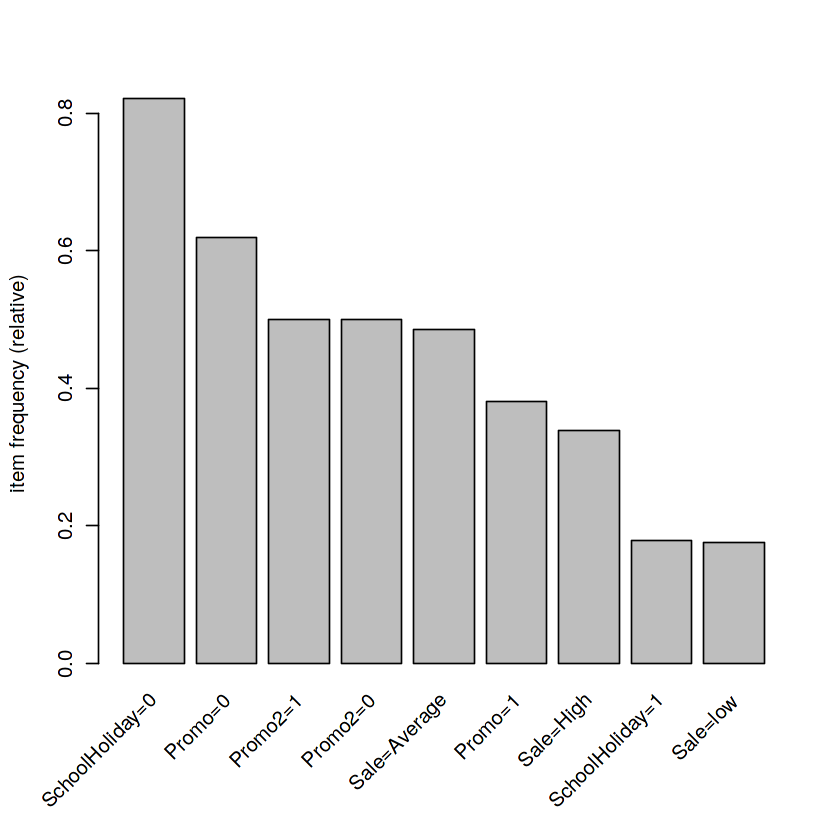

In [15]:
itemFrequencyPlot(trans, topN = 9)

The above visulization shows the frequency of item set like frequency of Promo2 is more than Promo etc.

Warning message:
“Unknown control parameters: type”

Available control parameters (with default values):
main	 =  Graph for 20 rules
nodeColors	 =  c("#66CC6680", "#9999CC80")
nodeCol	 =  c("#EE0000FF", "#EE0303FF", "#EE0606FF", "#EE0909FF", "#EE0C0CFF", "#EE0F0FFF", "#EE1212FF", "#EE1515FF", "#EE1818FF", "#EE1B1BFF", "#EE1E1EFF", "#EE2222FF", "#EE2525FF", "#EE2828FF", "#EE2B2BFF", "#EE2E2EFF", "#EE3131FF", "#EE3434FF", "#EE3737FF", "#EE3A3AFF", "#EE3D3DFF", "#EE4040FF", "#EE4444FF", "#EE4747FF", "#EE4A4AFF", "#EE4D4DFF", "#EE5050FF", "#EE5353FF", "#EE5656FF", "#EE5959FF", "#EE5C5CFF", "#EE5F5FFF", "#EE6262FF", "#EE6666FF", "#EE6969FF", "#EE6C6CFF", "#EE6F6FFF", "#EE7272FF", "#EE7575FF",  "#EE7878FF", "#EE7B7BFF", "#EE7E7EFF", "#EE8181FF", "#EE8484FF", "#EE8888FF", "#EE8B8BFF", "#EE8E8EFF", "#EE9191FF", "#EE9494FF", "#EE9797FF", "#EE9999FF", "#EE9B9BFF", "#EE9D9DFF", "#EE9F9FFF", "#EEA0A0FF", "#EEA2A2FF", "#EEA4A4FF", "#EEA5A5FF", "#EEA7A7FF", "#EEA9A9FF", "#EEABABFF", "#EEACACFF", "#EEAEAEFF", "#EEB0B0FF", "#EEB1B1FF", "#EEB3B3FF", "#EE

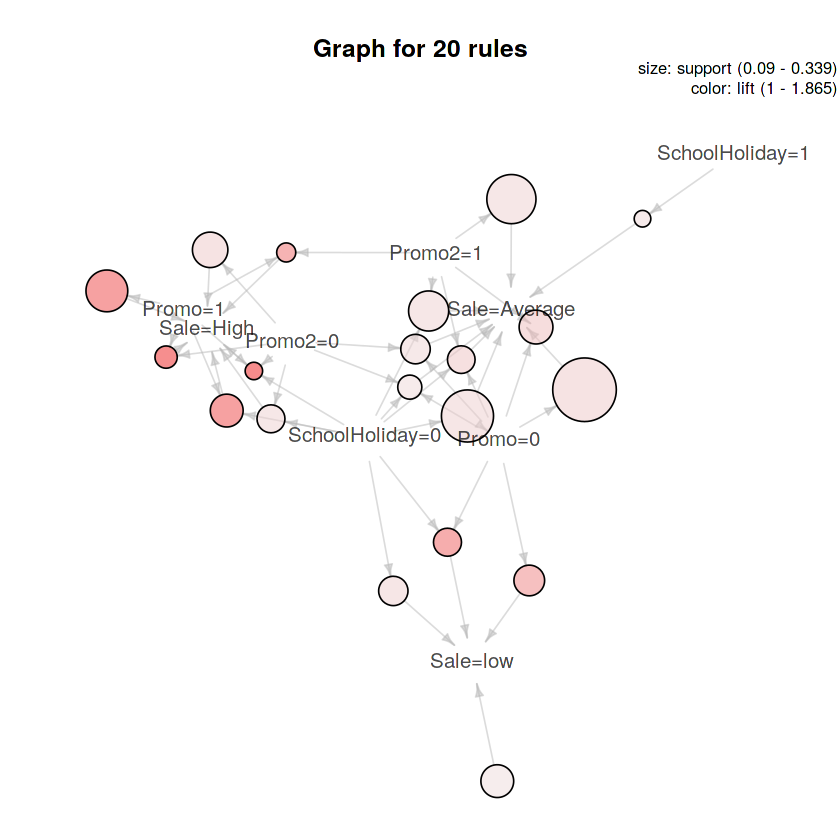

In [16]:
plot(rules[1:20],
method = "graph",
control = list(type = "rules"))

This representation gives us a graph model of items in our dataset.

The size of graph nodes is based on support levels and the colour on lift ratios. The incoming lines show the Antecedants or the LHS and the RHS is represented by names of items

The above graph shows us that most of our transactions were consolidated around **Promo** and .**Sale = high** . This means that when we doing **Promo*** our sale will go high. But in previous visulazation we have done less **Promo** than **Promo2**. So, we can increase **Promo** ,sale will go high.